In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import gridspec
from matplotlib import pylab as plt
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

# Chapter 6 - THE HAUNTED DAG & THE CAUSAL TERROR

I think there's not too much worth re-implementing in this chapter explicity as it's by and large conceptual, and most of the learning comes through sitting and thinking rather than reimplementing too much here.

The only thing I will take the time to do it to expand more on the $\textit{selection-distortion effect}$

Take two independent Unif(0,10) RVs, $X$ and $Y$. Let $Z = X + Y$. This is equivalent to the DAG below. Condition on Z being greater than 12. Points satisfying this condition are plotted as a different color to those not satisfying the condition, with the dividing surface between them.

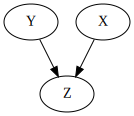

In [3]:
Dag = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"),
        ("Y", "Z")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

In [4]:
X = np.random.uniform(0, 10, size=70)
Y = np.random.uniform(0, 10, size=70)

In [5]:
Z = X+Y

In [6]:
x = np.linspace(0, 10)
y = 12 - x

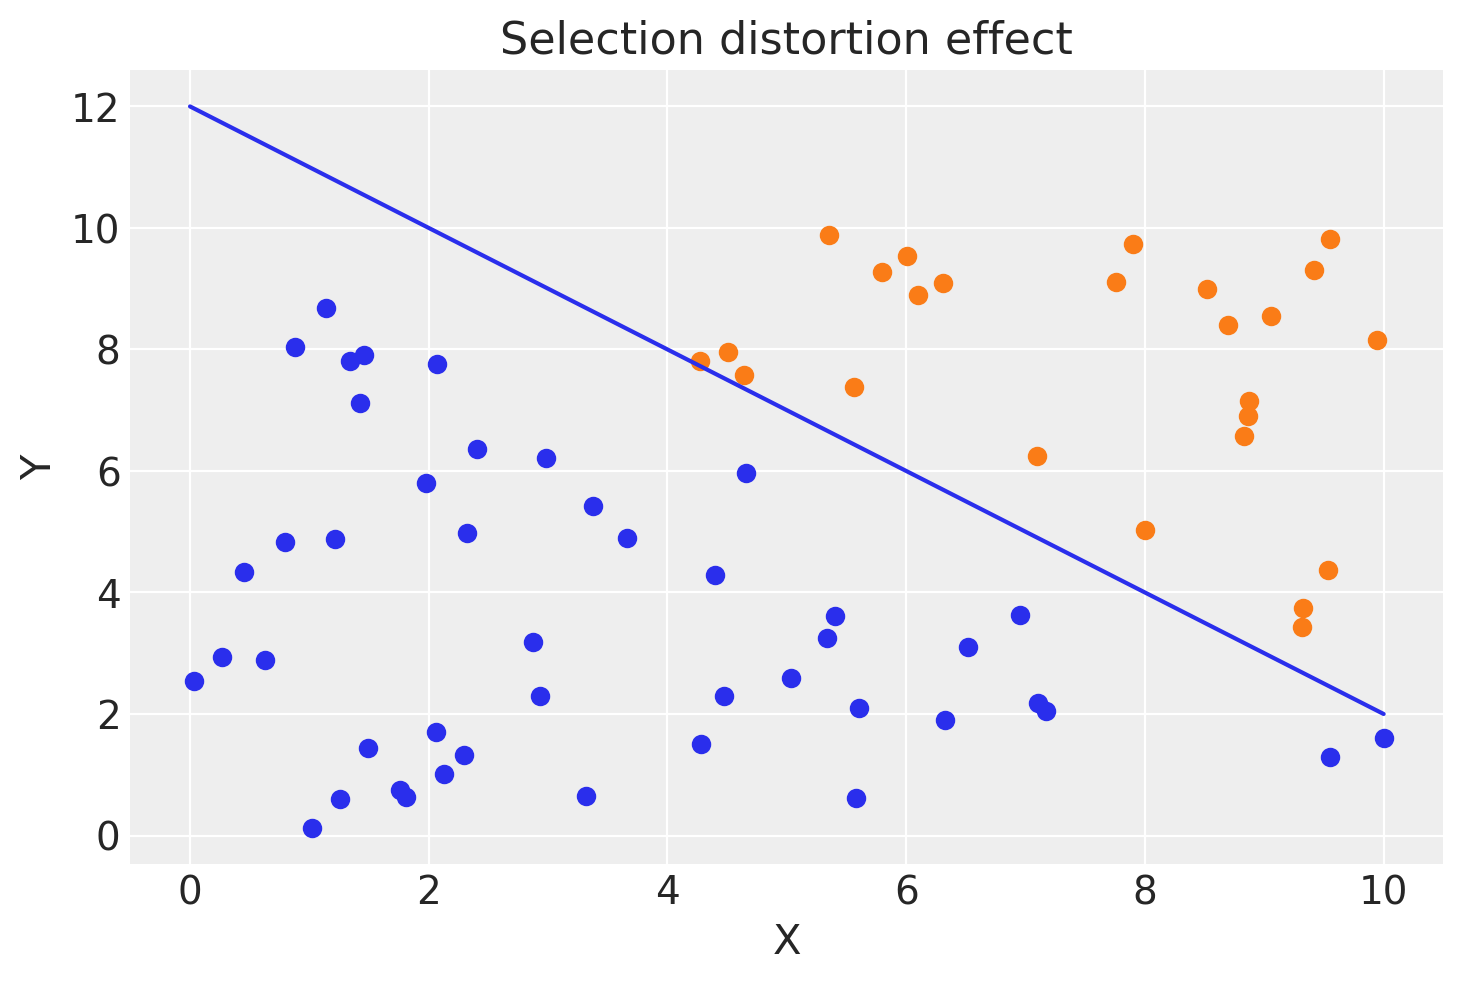

In [7]:
plt.scatter(X[Z <= 12], Y[Z <= 12])
plt.scatter(X[Z > 12], Y[Z > 12])
plt.plot(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Selection distortion effect")
plt.show()

Now, if we were to inspect only those points above our threshold of Z > 12 we would see that there's a strong correlation between X and Y, as we see below. Yet there was no causal path between the two in the original data generating process. Just the act of conditioning on Z induces a collider bias in the data points. Something similar is reflected if we also inspect those data points below the threshold. Thus this example of collider bias is illustrative of conditioning on variables willy nilly can lead our inferences deeply astray

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


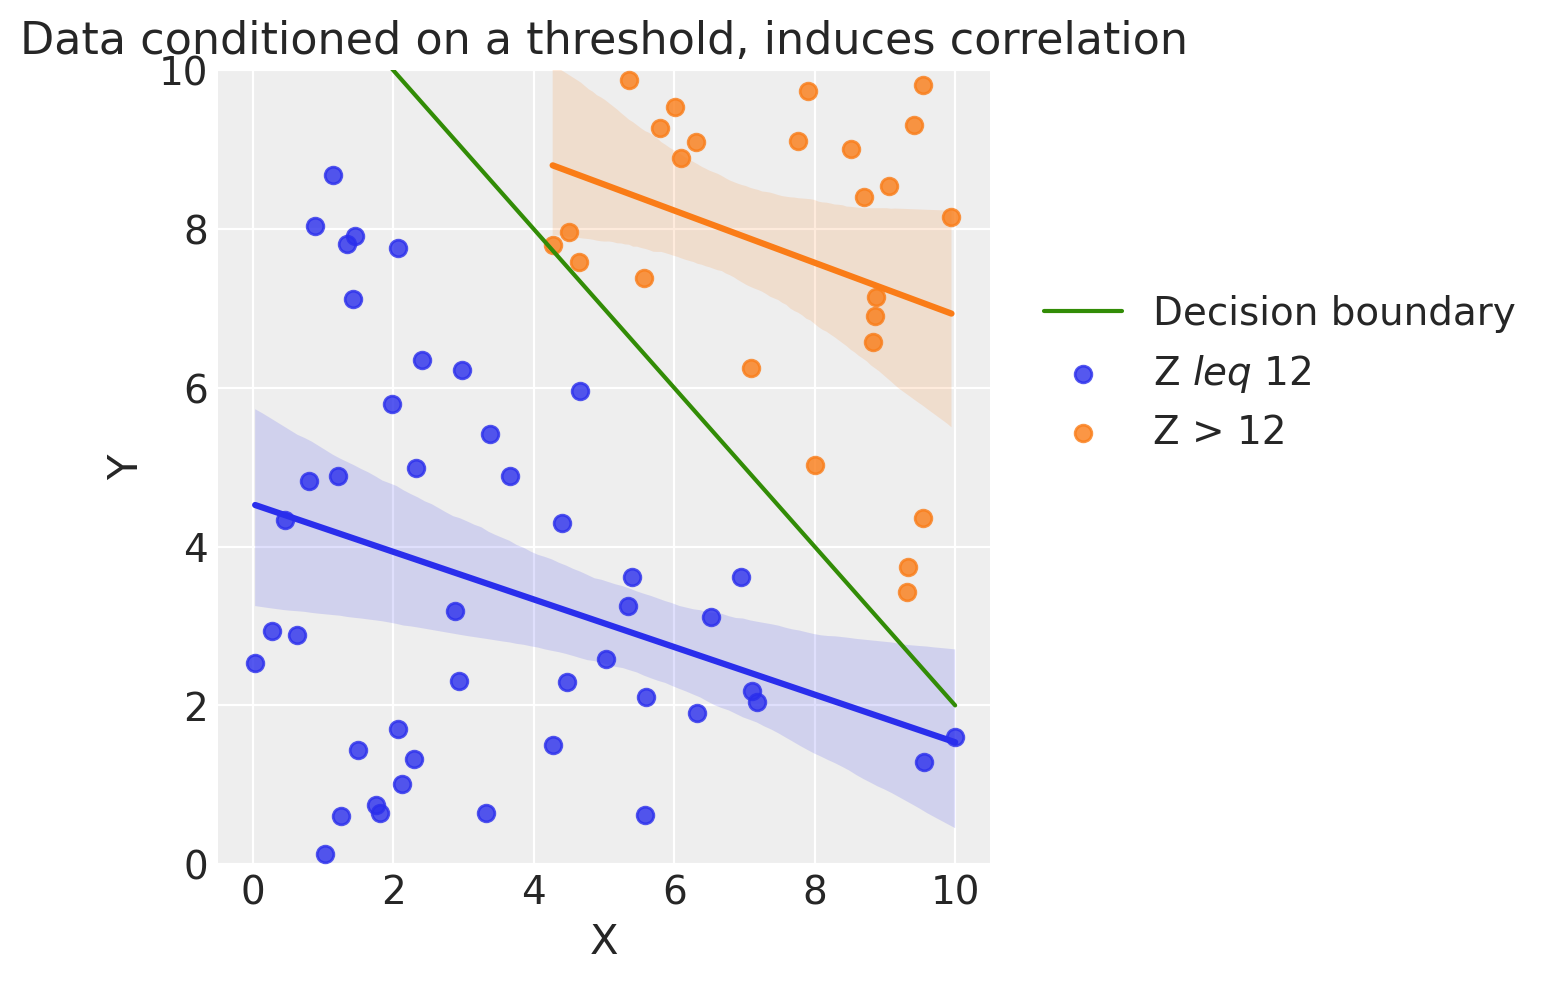

In [8]:
sns.regplot(X[Z <= 12], Y[Z <= 12], label="Z $leq$ 12")
sns.regplot(X[Z > 12], Y[Z > 12], label="Z > 12")
plt.plot(x, y, label="Decision boundary")
plt.ylim(0, 10)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc=(1.05, 0.5))
plt.title("Data conditioned on a threshold, induces correlation")
plt.show()

## End of Chapter Problems

6E1. List three mechanisms by which multiple regression can produce false inferences about causal effects

Answer: 1) Collider bias, by conditioning innappropriately on some variables.

2) It can assume that statistical relationships are exclusively linear.

3) Post treatment bias can obscure the actual degree to which a treatment actually impacts and outcome. This occurs because we can end up conditioning on some mediating variable which is part of the mechanism through which the treatment operates. When stated in the correct way, these fallacies can seem obviously stupid. Eg, I want to know how much anti-biotics stop me from dying from an infection. I then control for pathogen levels in the blood. I observe that once I've controlled for pathogen levels in the blood, anti-biotics show no association with dying from infection. But reducing pathogen levels is precisely the mechanism through which the anti-biotic operates.

4) Multicollinearities between predictor variables can also lead us wildly astray.

6E2. For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

Answer: See point 3) above

6E3. List the four elemental confounds. Can you explain the conditional dependencies of each?

Answer: The fork, the collider, the pipe, and the descendant.

The fork
X <- Z -> Y
Conditioned on the Z, X and Y should be independent of one another

The collider
X -> Z <- Y
X and Y are already indpendent of one another, but conditioning on Z will induce a spurious association

The Pipe
X -> Y -> Z
X and Z are indpendent conditional on Z.

The descendent
(See fig Below)
X and Z are independent of one another. However, conditioning on the D, the descendant of Y will induce a relationship between X and Z removing their conditional independence. This is becuase D contains information about Y, so conditioning on it is will inform us roughly what Y is. This will in turn produce a collider bias between X and Z

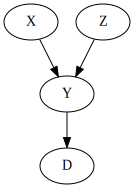

In [9]:
Dag = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "D"],
    edges=[
        ("X", "Y"),
        ("Z", "Y"),
        ("Y", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

6E4. How is a biased sample like conditioning on a collider? Think of the example at the open of the chapter

Answer: Biased samples can be produced in many ways, but often they have the characteristic of being like the selection distortion criterion. Eg, think of a study looking into health and IQ. Instead of uniformly sampling the whole population to get subjects for the study, instead what you do is go and sample military personnel, because they won't drop out of the study over a one year period like pesky civilians. This would obviously a biased sample. Why? Because one could plausibly imagine that in order to enter the military one needs to have some combination of health and IQ. If you are moderately unhealthy, but have a very high IQ, perhaps you can enter one of the intelligence divisions, whilst if you possess a low IQ and possess good health you could enter a more physically, but less cognitively demanding roll.

Let's call the sample group G, which is a random variable whose support is a partition of the population into, one element of which is the military. The reason this is an example of collider bias is that the two variables of interest X and Y determine which group you belong to, and whether you are in fact capable of being a memeber of certain groups, like the military. Thus conditioning on group, or your biased sample will induce a spurious relationship among the variables you're interested in. This is represented in the DAG below by showing that IQ and H determine your probability of being in a sample group.

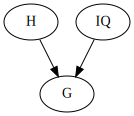

In [10]:
Dag = CausalGraphicalModel(
    nodes=["IQ", "H", "G"],
    edges=[
        ("IQ", "G"),
        ("H", "G")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

One could imagine (rather implausibly) that the pool of people who apply to be in the military is a uniform sample of the population, for which there may (perhaps again implausibly) be no relationship between IQ and health. If this were so, one could obtain perform the study in military applicants as they would be a representative, unbiased sample of the population. But once you condition on actually being in the military, you induce a spurious correlation between health and IQ, just through the selection distortion effect. We can visualise this below where there's some strange metric of health and IQ, and some combination of these two is required to get into the military.

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


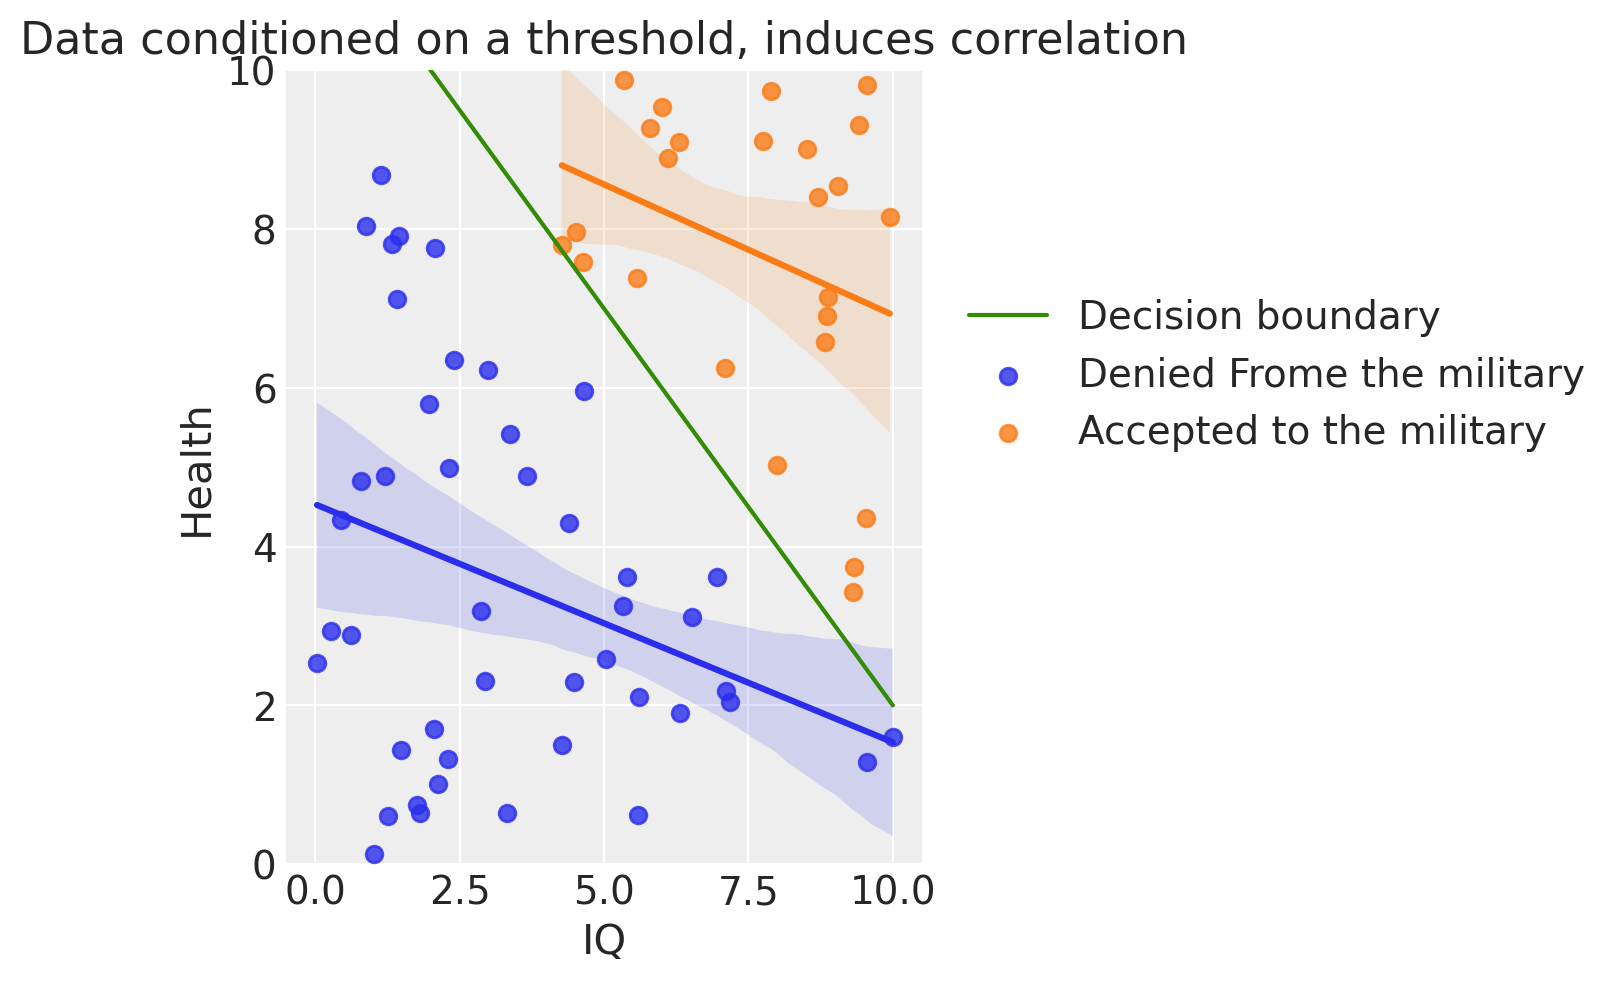

In [11]:
sns.regplot(X[Z <= 12], Y[Z <= 12], label="Denied Frome the military")
sns.regplot(X[Z > 12], Y[Z > 12], label="Accepted to the military")
plt.plot(x, y, label="Decision boundary")
plt.ylim(0, 10)
plt.xlabel("IQ")
plt.ylabel("Health")
plt.legend(loc=(1.05, 0.5))
plt.title("Data conditioned on a threshold, induces correlation")
plt.show()

6M1. Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which
variables should you condition on now?

Below is a horribly rendered version of the DAG found in the text with the V variable included in it.

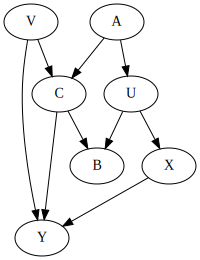

In [12]:
M1Dag = CausalGraphicalModel(
    nodes=["A", "B", "C", "U", "X", "Y", "V"],
    edges=[
        ("A", "C"),
        ("A", "U"),
        ("U", "B"),
        ("C", "B"),
        ("C", "Y"),
        ("U", "X"),
        ("X", "Y"),
        ("V", "C"),
        ("V", "Y")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
M1Dag.draw()

In [13]:
M1Dag.get_all_backdoor_paths("X", "Y")

[['X', 'U', 'A', 'C', 'Y'],
 ['X', 'U', 'A', 'C', 'V', 'Y'],
 ['X', 'U', 'B', 'C', 'Y'],
 ['X', 'U', 'B', 'C', 'V', 'Y']]

In [14]:
# get the set of all backdoor adjustments between X and Y
M1Dag.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'U'}),
           frozenset({'A', 'B', 'C', 'U'}),
           frozenset({'A', 'B', 'U', 'V'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'U', 'V'}),
           frozenset({'B', 'U', 'V'}),
           frozenset({'B', 'C', 'U', 'V'}),
           frozenset({'A'}),
           frozenset({'A', 'C'}),
           frozenset({'C', 'V'}),
           frozenset({'A', 'C', 'V'}),
           frozenset({'B', 'C', 'V'}),
           frozenset({'A', 'V'}),
           frozenset({'A', 'U', 'V'}),
           frozenset({'B', 'U'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'C', 'U'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'B', 'C', 'V'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'C', 'U', 'V'}),
           frozenset({'A', 'U'}),
           frozenset({'A', 'C', 'U', 'V'}),
           frozenset({'A', 'B', 'C', 'U', 'V'})})

There are now 5 paths from X to Y.
(1) X ← U ← A → C → Y

(2) X ← U → B ← C → Y← V

(3) X ← U ← A → C ← V →Y

(4) X ← U → B ← C ← V → Y

(5) X → Y


6M2. Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among
predictors before including them in a model. This is a bad procedure, because what matters is the
conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation
between X and Z is very large. Then include both in a model prediction Y. Do you observe any
multicollinearity? Why or why not? What is different from the legs example in the chapter?


In [15]:
# simulate data according to the DAG
x = np.random.normal(size=100)
z = np.random.normal(loc=2*x)
y = np.random.normal(loc=4*z)

In [16]:
def standardize(x): return (x - np.mean(x))/np.std(x)

In [17]:
# standardise the data
sx, sy, sz = standardize(x), standardize(y), standardize(z)
data = pd.DataFrame(np.array([sx, sy, sz]).T, columns=["sx", "sy", "sz"])
data.corr()  # get the correlation matrix

,sx,sy,sz
sx,1.000000,0.905492,0.911976
sy,0.905492,1.000000,0.994636
sz,0.911976,0.994636,1.000000


In [18]:
with pm.Model() as pipe:
    a = pm.Normal("a", mu=0, sd=0.2)
    bx = pm.Normal("bx", mu=0, sd=0.5)
    bz = pm.Normal("bz", mu=0, sd=0.5)
    mu = a + bx*sx + bz+sz
    sigma = pm.Exponential("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=sy)
    sample = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8913389387173435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9064059025317579, but should be close to 0.8. Try to increase the number of tuning steps.


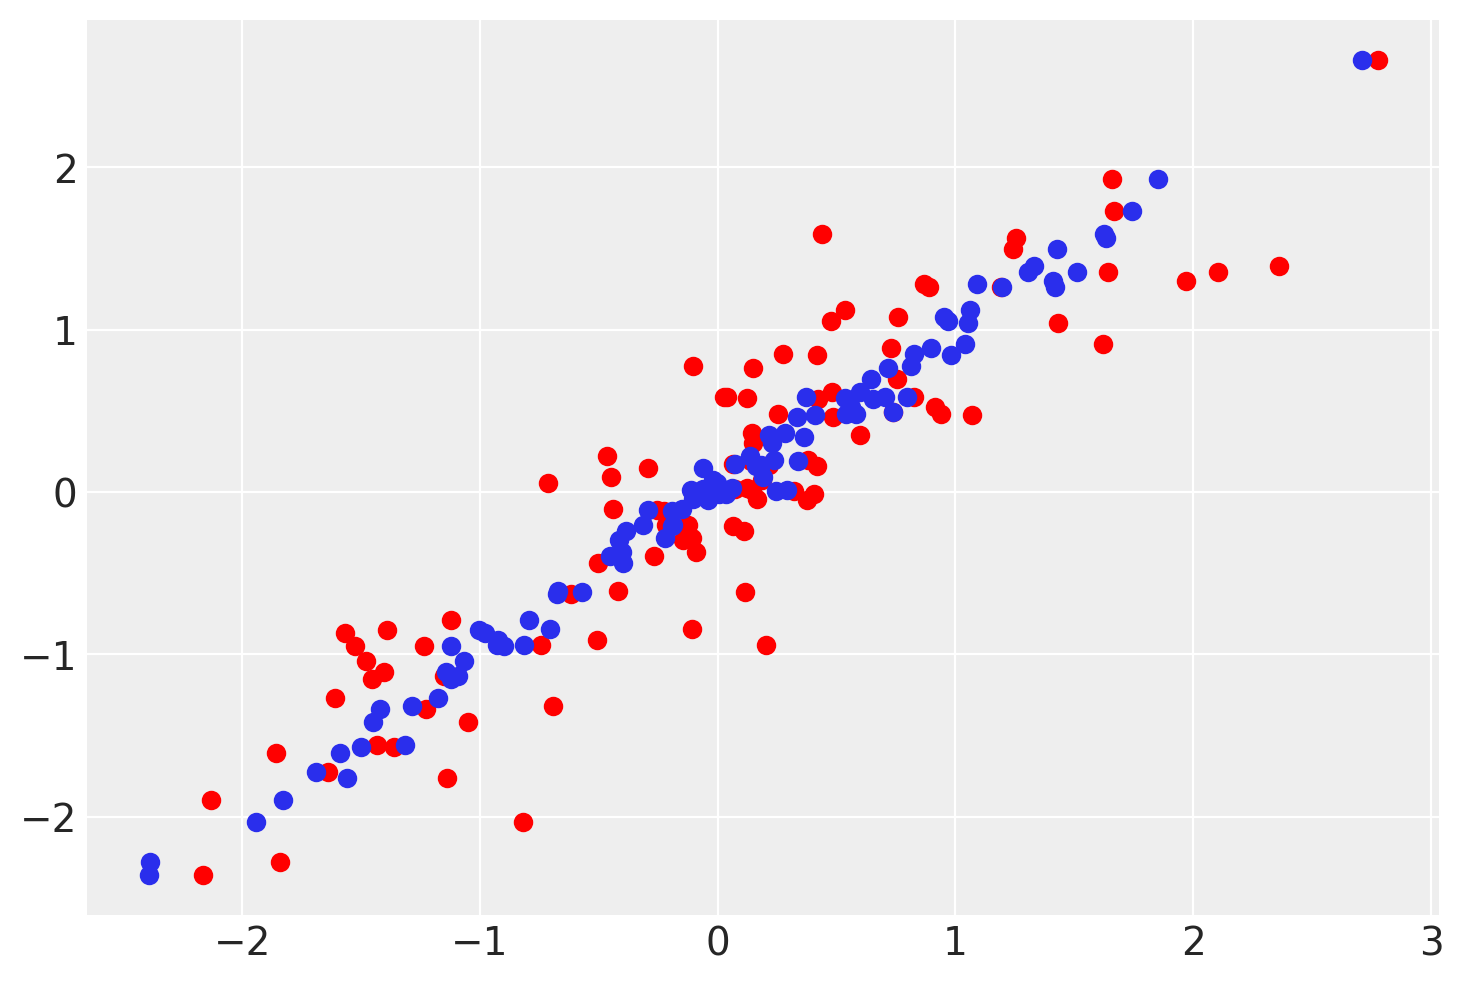

In [19]:
plt.scatter(sx, sy, c="r")
plt.scatter(sz, sy)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

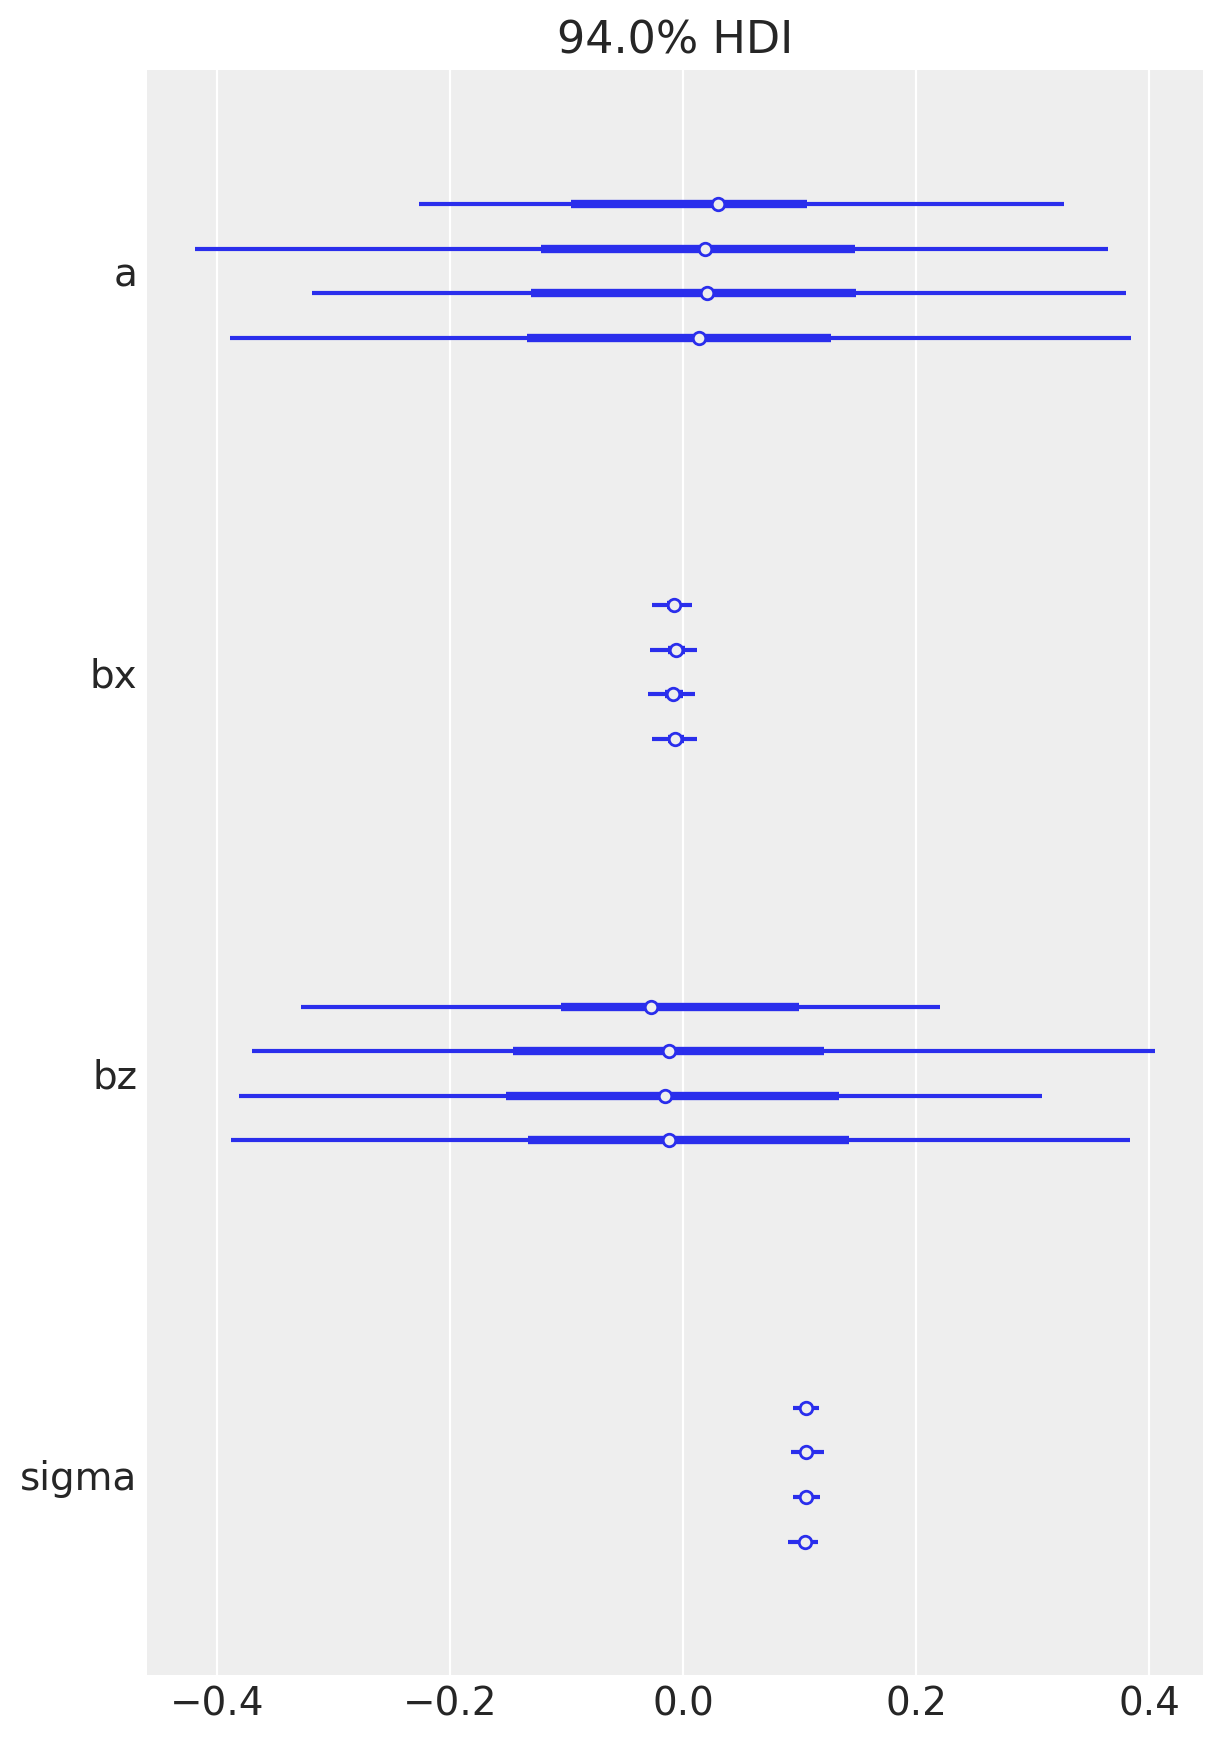

In [20]:
pm.forestplot(sample)

In [21]:
pm.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.012,0.193,-0.325,0.384,0.009,0.008,452.0,267.0,465.0,284.0,1.01
bx,-0.007,0.011,-0.028,0.012,0.000,0.000,795.0,442.0,788.0,491.0,1.00
bz,-0.011,0.193,-0.391,0.308,0.009,0.008,454.0,268.0,468.0,292.0,1.02
sigma,0.105,0.007,0.092,0.117,0.000,0.000,787.0,784.0,793.0,679.0,1.01


Multicollinearity is observed in this data set, because Z was produced from X. This is different to the leg example where the two predictor variables were prodced by a third confounding variable. In this case however collinearity was induced by the causal effect and not by an unobserved confounder as in the leg and milk examples in the book.

# ^ this is sooo strange an I don't have a good explanation for it

6M3. Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

Answer:

Top left, control for Z

Top right, control for nothing

Bottom left, control for nothing

Bottom right, control for A

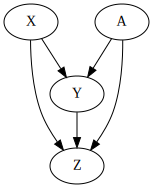

In [22]:
M2Dag = CausalGraphicalModel(
    nodes=["A", "Z", "X", "Y"],
    edges=[
        ("X", "Y"),
        ("X", "Z"),
        ("Y", "Z"),
        ("A", "Z"),
        ("A", "Y")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
M2Dag.draw()

In [23]:
# get the set of all backdoor adjustments between X and Y
M1Dag.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'U'}),
           frozenset({'A', 'B', 'C', 'U'}),
           frozenset({'A', 'B', 'U', 'V'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'U', 'V'}),
           frozenset({'B', 'U', 'V'}),
           frozenset({'B', 'C', 'U', 'V'}),
           frozenset({'A'}),
           frozenset({'A', 'C'}),
           frozenset({'C', 'V'}),
           frozenset({'A', 'C', 'V'}),
           frozenset({'B', 'C', 'V'}),
           frozenset({'A', 'V'}),
           frozenset({'A', 'U', 'V'}),
           frozenset({'B', 'U'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'C', 'U'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'B', 'C', 'V'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'C', 'U', 'V'}),
           frozenset({'A', 'U'}),
           frozenset({'A', 'C', 'U', 'V'}),
           frozenset({'A', 'B', 'C', 'U', 'V'})})

6H1. Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

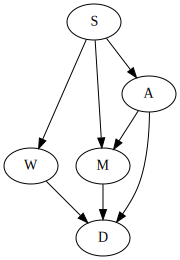

In [24]:
Waffle = CausalGraphicalModel(
    nodes=["S", "M", "W", "A", "D"],
    edges=[
        ("S", "W"),
        ("S", "M"),
        ("S", "A"),
        ("A", "M"),
        ("A", "D"),
        ("M", "D"),
        ("W", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Waffle.draw()

In [26]:
data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")

We can take the DAG from the book and actually run it to see if DAG W is independent of D once we have conditioned on whether a state is in the South or not. By using the backdoor principle, we can figure out the total causal effect of W on D by conditioning on S.

In [27]:
# standardise the data
sw, sd = standardize(data.WaffleHouses), standardize(data.Divorce)

<ipython-input-28-d0b0060f94c8>:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


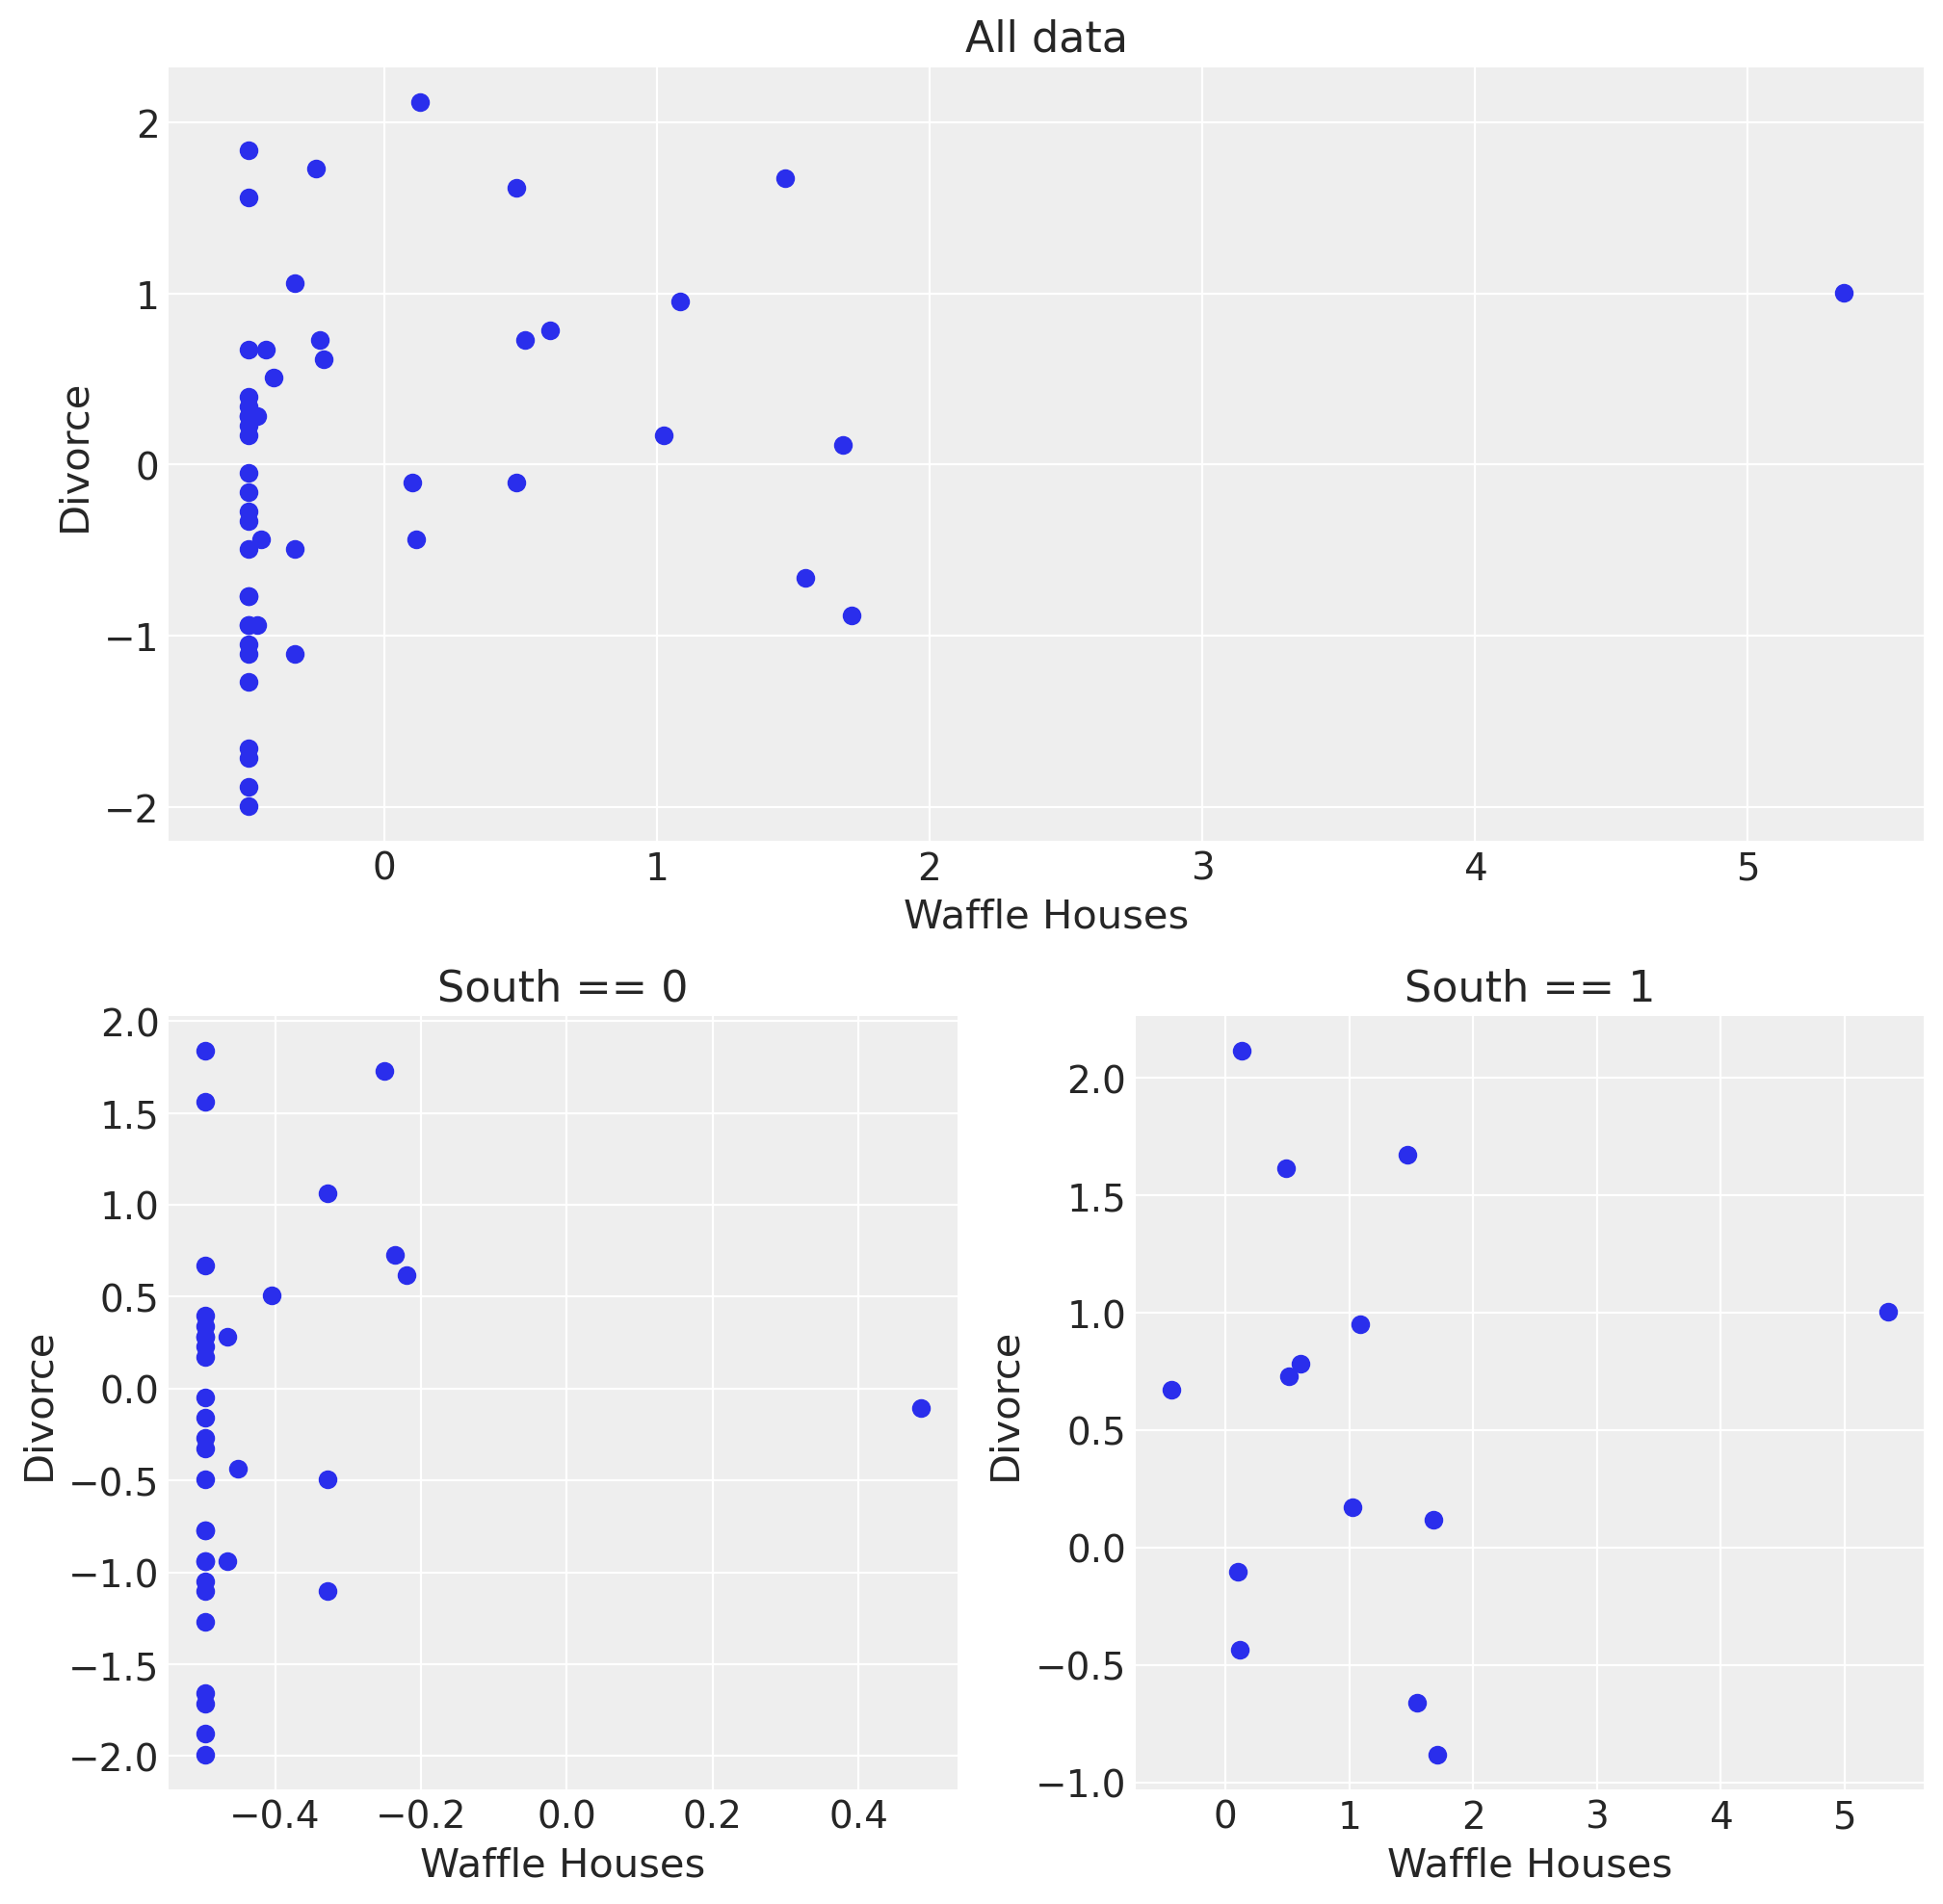

In [28]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, :])
ax0.scatter(sw, sd)
ax0.set_xlabel("Waffle Houses")
ax0.set_ylabel("Divorce")
ax0.set_title("All data")

ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(sw[data.South == 0], sd[data.South == 0])
ax1.set_title("South == 0")
ax1.set_xlabel("Waffle Houses")
ax1.set_ylabel("Divorce")

ax2 = fig.add_subplot(gs[1, 1])
ax2.scatter(sw[data.South == 1], sd[data.South == 1])
ax2.set_title("South == 1")
ax2.set_xlabel("Waffle Houses")
ax2.set_ylabel("Divorce")

fig.tight_layout()
plt.show()

We can use pymc3 to perform the regression conditioned on whether each state is in the south of not.

In [29]:
# Regression for all the data
with pm.Model() as Waffle_Model:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sw
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 6 seconds.


In [30]:
pm.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.006,0.118,-0.227,0.226,0.003,0.004,1281.0,452.0,1283.0,491.0,1.01
b,0.234,0.134,-0.038,0.460,0.004,0.003,940.0,933.0,943.0,583.0,1.00
sigma,1.003,0.104,0.807,1.194,0.003,0.002,1062.0,1029.0,1065.0,781.0,1.00


In [31]:
# Regression for the categorical variables
with pm.Model() as Waffle_south:
    a = pm.Normal("a", mu=0, sd=0.2, shape=2)
    b = pm.Normal("b", mu=0, sd=0.5, shape=2)
    mu = a[data["South"]] + b[data["South"]]*sw
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample_south = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 5 seconds.


In [32]:
pm.summary(sample_south)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.040,0.156,-0.313,0.265,0.005,0.005,832.0,573.0,829.0,752.0,1.0
a[1],0.145,0.170,-0.158,0.466,0.006,0.005,946.0,696.0,947.0,658.0,1.0
b[0],0.340,0.346,-0.293,0.993,0.012,0.009,867.0,750.0,872.0,763.0,1.0
b[1],0.126,0.161,-0.164,0.423,0.006,0.004,802.0,721.0,802.0,826.0,1.0
sigma,0.988,0.104,0.789,1.164,0.003,0.002,1112.0,1069.0,1164.0,761.0,1.0


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packag

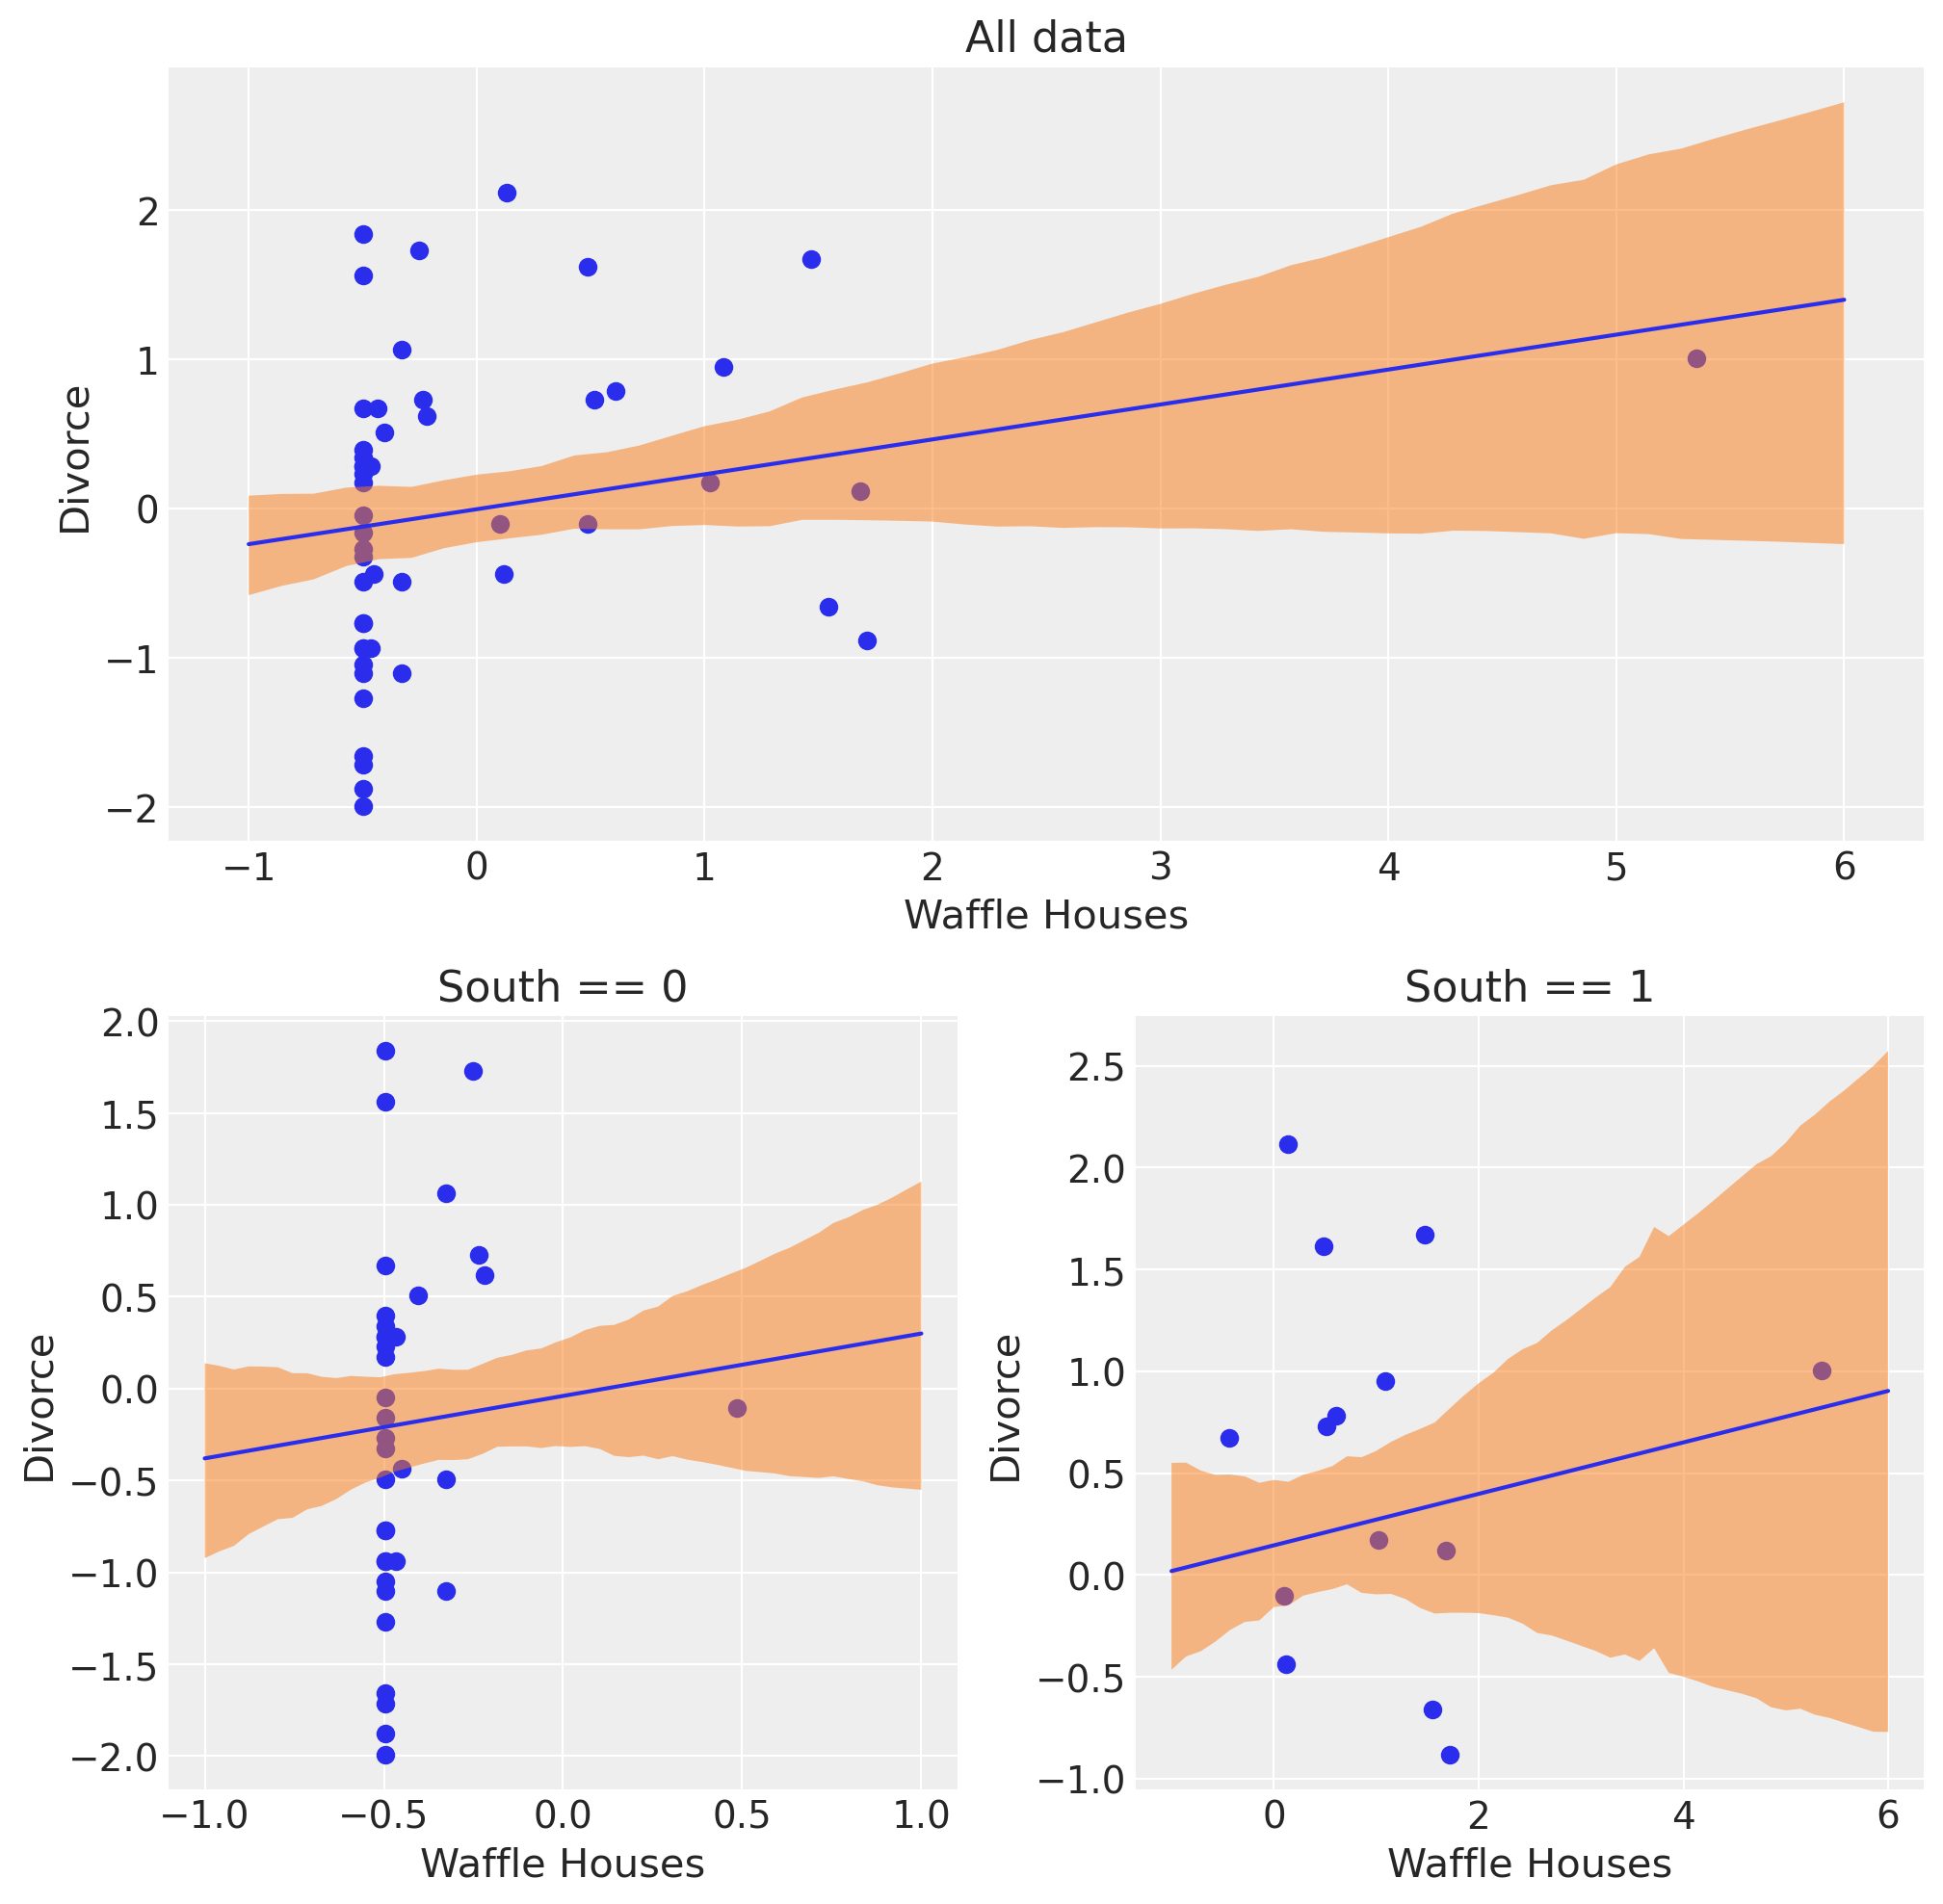

In [33]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2)


"""
Total data fit
"""

x = np.linspace(-1, 6)
post_total = sample["a"] + np.outer(x, sample["b"])
interval = pm.hpd(post_total.T)

ax0 = fig.add_subplot(gs[0, :])
ax0.scatter(sw, sd)
ax0.fill_between(x, interval[:, 0], interval[:, 1], alpha=0.5)
ax0.plot(x, np.mean(post_total, axis=1))
ax0.set_xlabel("Waffle Houses")
ax0.set_ylabel("Divorce")
ax0.set_title("All data")


"""
North data fit
"""
x = np.linspace(-1, 1)
post_North = sample_south["a"][:, 0] + np.outer(x, sample_south["b"][:, 0])
interval = pm.hpd(post_North.T)
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(sw[data.South == 0], sd[data.South == 0])
ax1.plot(x, np.mean(post_North, axis=1))
ax1.fill_between(x, interval[:, 0], interval[:, 1], alpha=0.5)
ax1.set_title("South == 0")
ax1.set_xlabel("Waffle Houses")
ax1.set_ylabel("Divorce")

"""
South data fit
"""
x = np.linspace(-1, 6)
post_South = sample_south["a"][:, 1] + np.outer(x, sample_south["b"][:, 1])
interval = pm.hpd(post_South.T)
ax2 = fig.add_subplot(gs[1, 1])
ax2.scatter(sw[data.South == 1], sd[data.South == 1])
ax2.plot(x, np.mean(post_South, axis=1))
ax2.fill_between(x, interval[:, 0], interval[:, 1], alpha=0.5)
ax2.set_title("South == 1")
ax2.set_xlabel("Waffle Houses")
ax2.set_ylabel("Divorce")

fig.tight_layout()
plt.show()

We can see that when we regress on all of the data, the probability of their being no association between #wafflehouse and divorce rate is fairly inconsitent with no association. That is the amount of mass in the posterior surrounding b=0 is very small. Once we condition on the states being southern or not however we see the effect becomes consistent with being zero.

(array([0.02277238, 0.03795396, 0.41749354, 1.16139113, 2.33796384,
        2.23928355, 1.10825559, 0.22013296, 0.03036317, 0.01518158]),
 array([-0.5198136 , -0.38807503, -0.25633647, -0.1245979 ,  0.00714066,
         0.13887923,  0.27061779,  0.40235635,  0.53409492,  0.66583348,
         0.79757205]),
 <BarContainer object of 10 artists>)

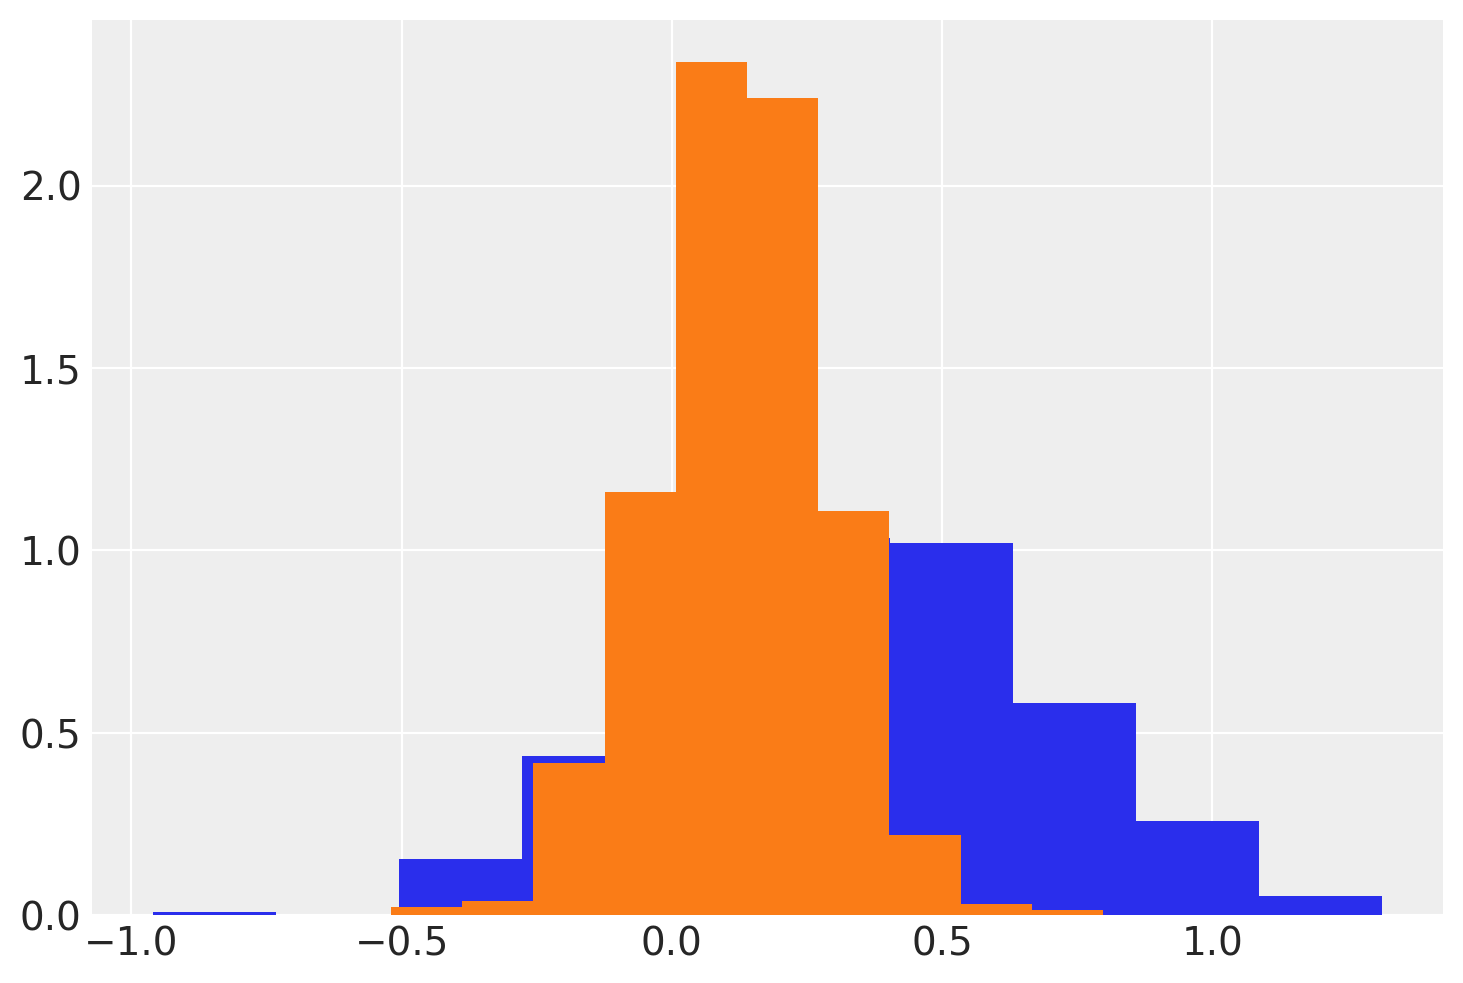

In [34]:
plt.hist(sample_south["b"][:, 0], density=True)
plt.hist(sample_south["b"][:, 1], density=True)

We can obtain the marginal distribution for $\beta$ by averaging the distributions over the groups. $Pr(\beta) = \sum Pr(\beta | g) Pr(g)$


# I perform a truly terrible approximation of this average below. I should think harder about how to actually do this

In [35]:
ps = data.South.sum()/data.shape[0]

In [36]:
Nor = np.random.choice(sample_south["b"][:, 0], size=280)
Sou = np.random.choice(sample_south["b"][:, 1], size=720)

In [37]:
total_eff = np.concatenate([Nor, Sou])

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


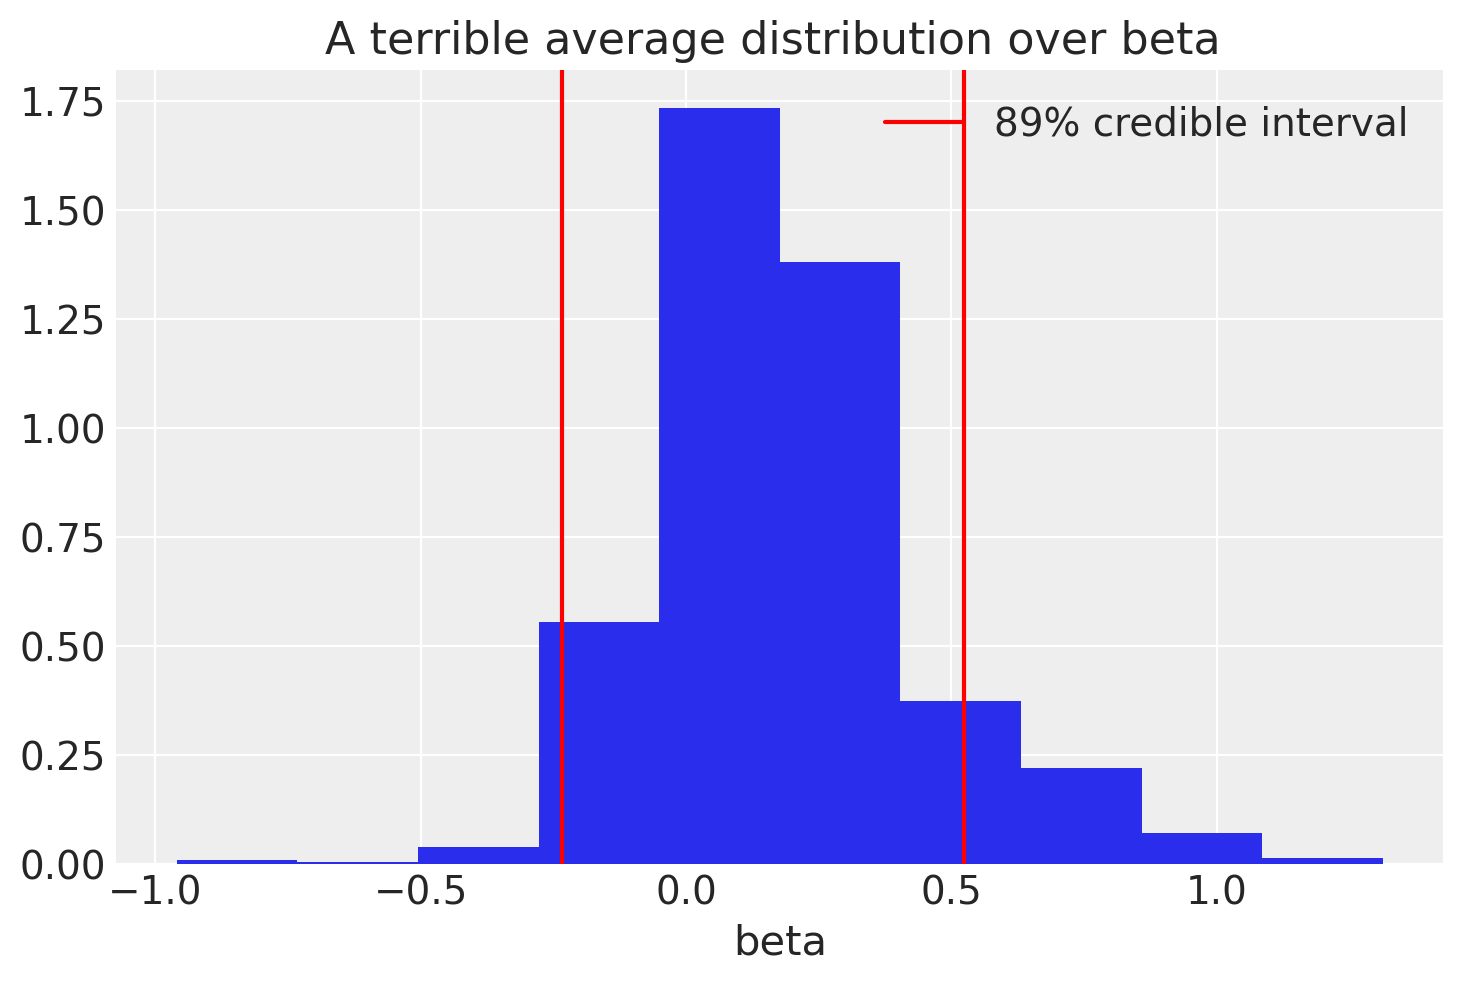

In [38]:
plt.title("A terrible average distribution over beta ")
plt.hist(total_eff, density=True)
plt.axvline(pm.hpd(total_eff, hdi_prob=0.89)[
            0], c="r", label="89% credible interval")
plt.axvline(pm.hpd(total_eff, hdi_prob=0.89)[1], c="r")
plt.xlabel("beta")
plt.legend()
plt.show()

In [39]:
pm.hpd(total_eff, hdi_prob=0.89)

array([-0.23460593,  0.52344658])

This is consistent with there being no effect once the state being in the South or not has been controlled for.

6H2. Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data

Answer: Instead of actually trying to figure out the conditional independencies in the DAG myself, I'll just piggyback on the software.



In [40]:
Waffle.get_all_independence_relationships()

[('M', 'W', {'S'}),
 ('M', 'W', {'A', 'S'}),
 ('D', 'S', {'A', 'M', 'W'}),
 ('W', 'A', {'S'}),
 ('W', 'A', {'M', 'S'})]

There are quite a lot of conditional independence relations here to test. I could essentially repeat the strategy I used above, but this would be awfully time consuming. Also, it's not clear to me (nor the literature https://onlinelibrary.wiley.com/doi/full/10.1002/wics.1489 apparently) that correlation is a particularly clever way of testing for conditional independence between two variables. For two variables to be conditionally independent, it's necessary for there to be no correlation, but it is by no means sufficient. I defer testing all of these conditional independence relations until I know of a better way of actually testing it.

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from
30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to
8 individuals. Each group maintains its own urban territory. Some territories are larger than others.
The area variable encodes this information. Some territories also have more avgfood than others.
We want to model the weight of each fox. For the problems below, assume the following DAG:


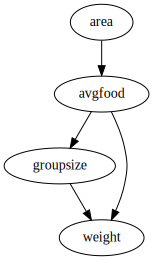

In [41]:
Foxy = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Foxy.draw()

In [42]:
foxy = pd.read_csv("./data/foxes.csv", delimiter=";")

6H3. Use a model to infer the total causal influence of area on weight. Would increasing the area
available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the
possible outcome range

Answer: To find the total causal impact of area on weight, we simply regress weight on area with no conditioning. This is because the effect of area on weight is mediated through the other variables.

In [43]:
foxy.head(2)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84


In [44]:
# standardise the continuous variables
sf, sa, sw = standardize(foxy.avgfood), standardize(
    foxy.area), standardize(foxy.weight)

In [45]:
# impact of area on weight
with pm.Model() as area_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sa
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=sw)
    sample = pm.sample(draws=250, chains=4)
    prior_preds = pm.sample_prior_predictive(samples=100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Waiting for existing lock by process '16304' (I am process '15241')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '14621' (I am process '15241')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 19 seconds.


In [46]:
pm.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.085,-0.163,0.156,0.002,0.003,1231.0,513.0,1242.0,742.0,1.01
b,0.014,0.094,-0.179,0.171,0.003,0.003,1366.0,567.0,1359.0,780.0,1.00
sigma,1.015,0.070,0.882,1.139,0.002,0.001,1340.0,1314.0,1357.0,780.0,1.00


In [47]:
x = np.linspace(-1, 1)
# posterior samples on lines
post_dist = sample["a"] + np.outer(x, sample["b"])
cred_intervals = pm.hpd(post_dist.T,)  # credibly intervals
post_preds = np.random.normal(loc=post_dist, scale=sample["sigma"])
pred_intervals = pm.hpd(post_preds.T,)  # prediction intervals

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


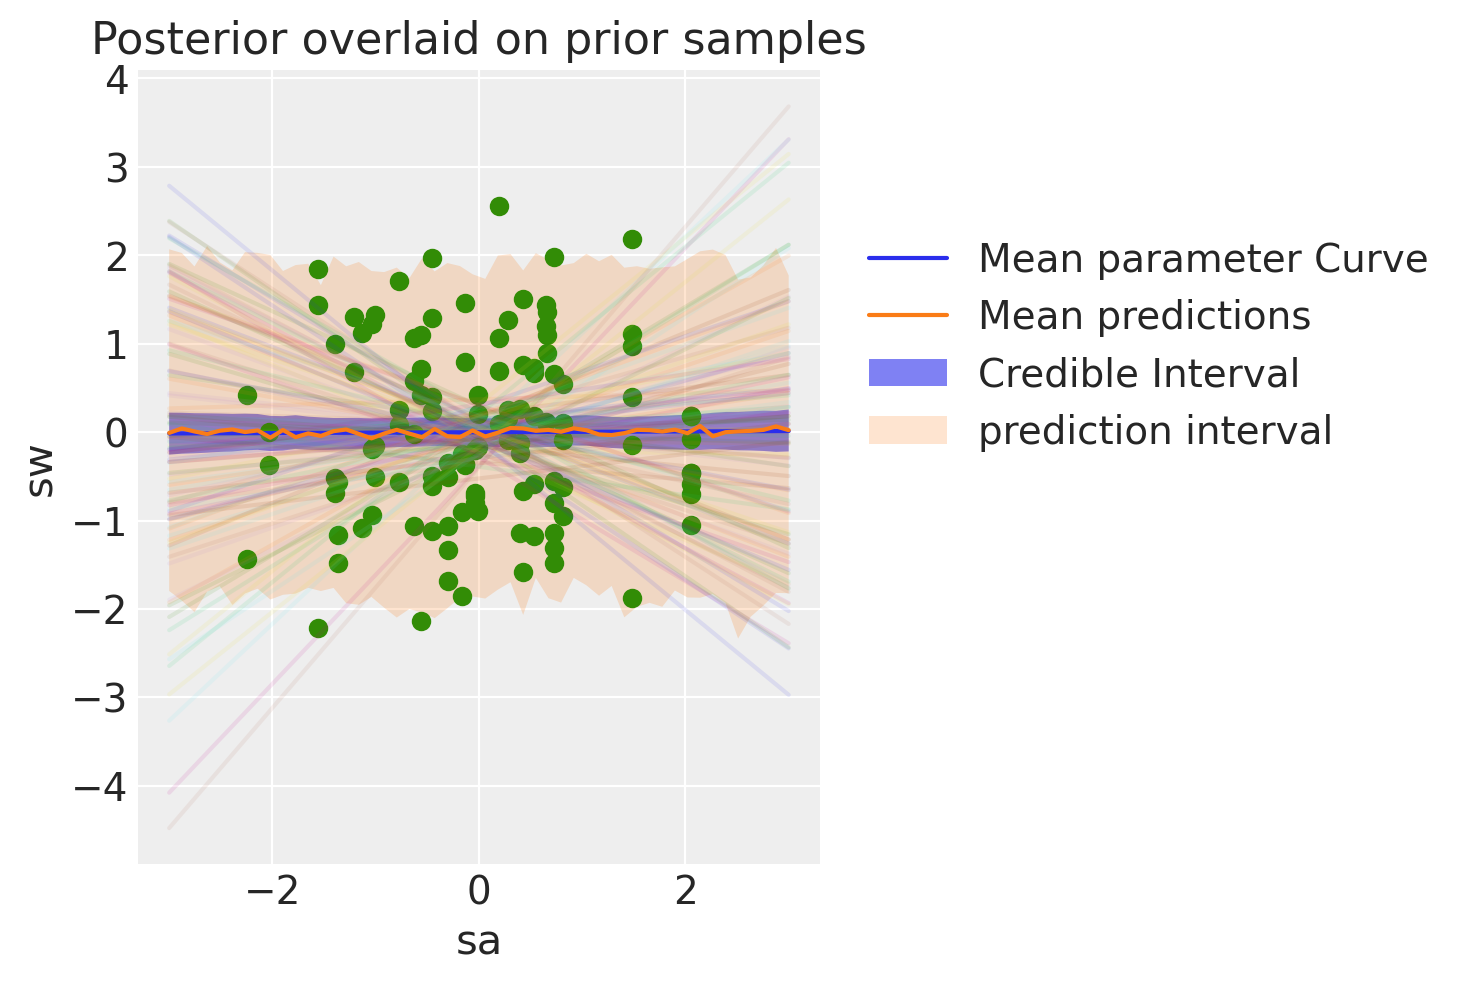

In [48]:
# plot the prior predictive distribution
x = np.linspace(-3, 3)
for a, b in zip(prior_preds["a"], prior_preds["b"]):
    y = a + b*x
    plt.plot(x, y, alpha=0.1)

plt.plot(x, np.mean(post_dist, axis=1), label="Mean parameter Curve")
plt.fill_between(
    x, cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.6, label="Credible Interval")
plt.plot(x, np.mean(post_preds, axis=1), label="Mean predictions")
plt.fill_between(
    x, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2, label="prediction interval")
plt.scatter(sa, sw)
plt.title("Posterior overlaid on prior samples")
plt.xlabel("sa")
plt.ylabel("sw")
plt.legend(loc=(1.05, 0.5))
plt.show()

If there is a total direct effect of area on weight, it's very weak. I don't believe that we need to condition on any of the mediating variables between area and weight in this example because there is no back door confounding the original effect.

The posterior prediction intervals for this causal effect seem to be consistent with the data that was actually observed.

6H4. Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

Answer: There are no confounding backdoors between average food and weight in this model. Therefore no adjustments need to be made, and we can simply regress weight onto food without any further complications.


In [49]:
# impact of average food on weight
with pm.Model() as food_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sf
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=sw)
    food_sample = pm.sample(draws=250, chains=4)
    #prior_preds = pm.sample_prior_predictive(samples = 100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 9 seconds.


In [50]:
x = np.linspace(-2, 2)
# posterior samples on lines
post_dist = food_sample["a"] + np.outer(x, food_sample["b"])
cred_intervals = pm.hpd(post_dist.T,)  # credibly intervals
post_preds = np.random.normal(loc=post_dist, scale=food_sample["sigma"])
pred_intervals = pm.hpd(post_preds.T,)  # prediction intervals

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


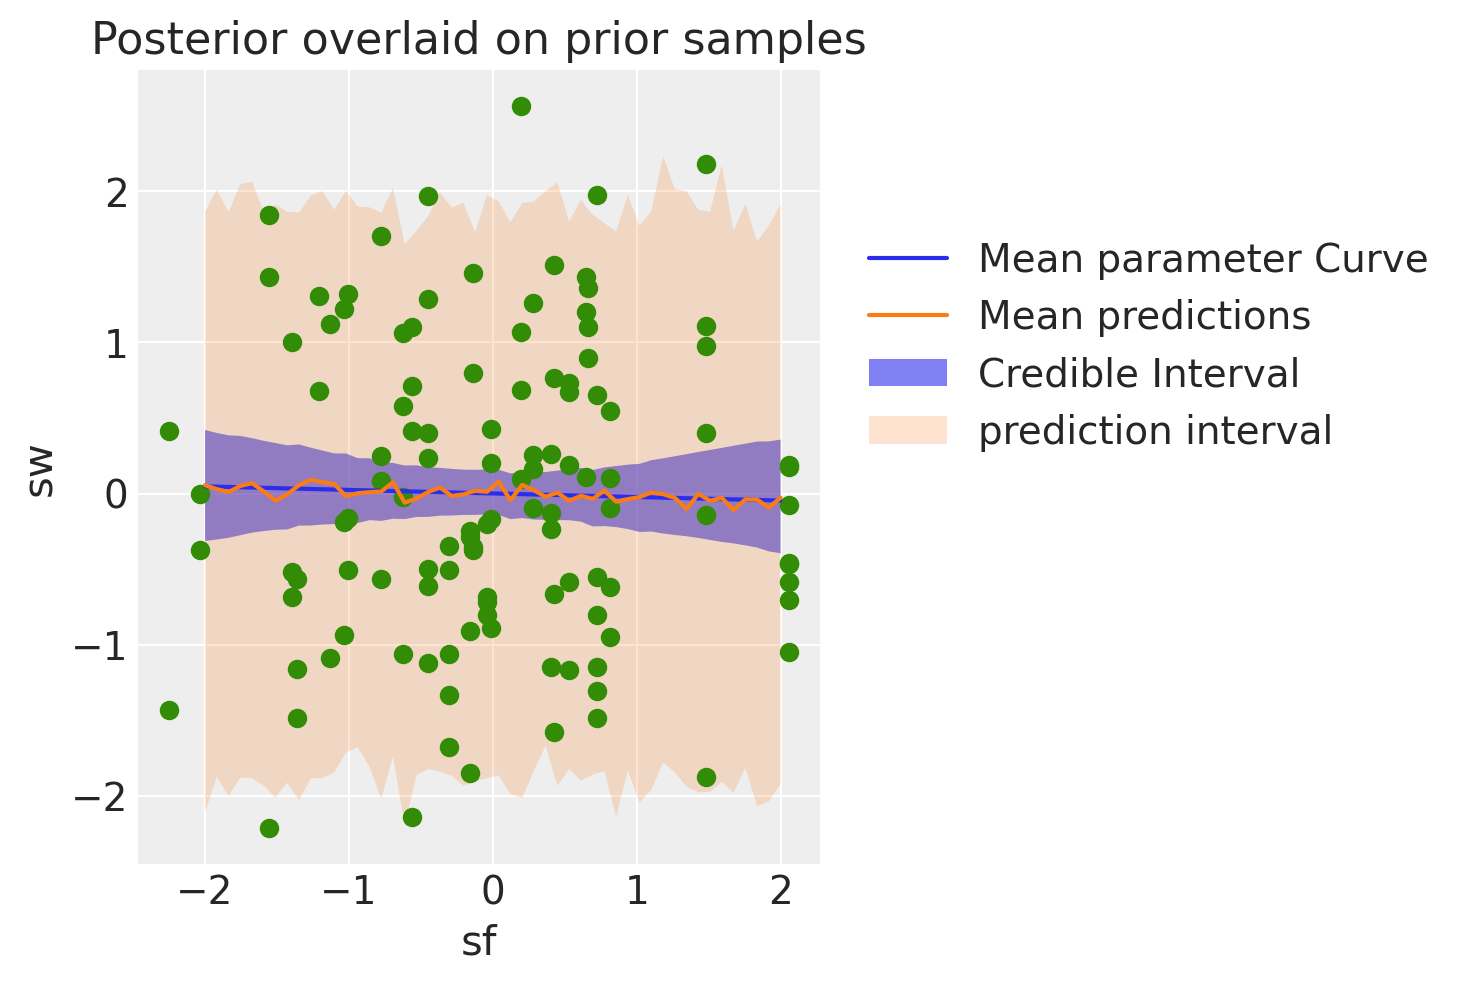

In [51]:
plt.plot(x, np.mean(post_dist, axis=1), label="Mean parameter Curve")
plt.fill_between(
    x, cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.6, label="Credible Interval")
plt.plot(x, np.mean(post_preds, axis=1), label="Mean predictions")
plt.fill_between(
    x, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2, label="prediction interval")
plt.scatter(sa, sw)
plt.title("Posterior overlaid on prior samples")
plt.xlabel("sf")
plt.ylabel("sw")
plt.legend(loc=(1.05, 0.5))
plt.show()

Again, the average food appears to have no overall impact. Presumably this is due to a masking effect. As average food in a territory goes up, so does the group size, which simply means the larger food supply is distributed among more foxes.

6H5. Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

In this case, the effect of groupsize on weight is confounded by the average food in the territory so we need to control for average food in this model.

In [52]:
foxy.groupsize.drop_duplicates().values - 2

array([0, 1, 5, 2, 6, 3, 4])

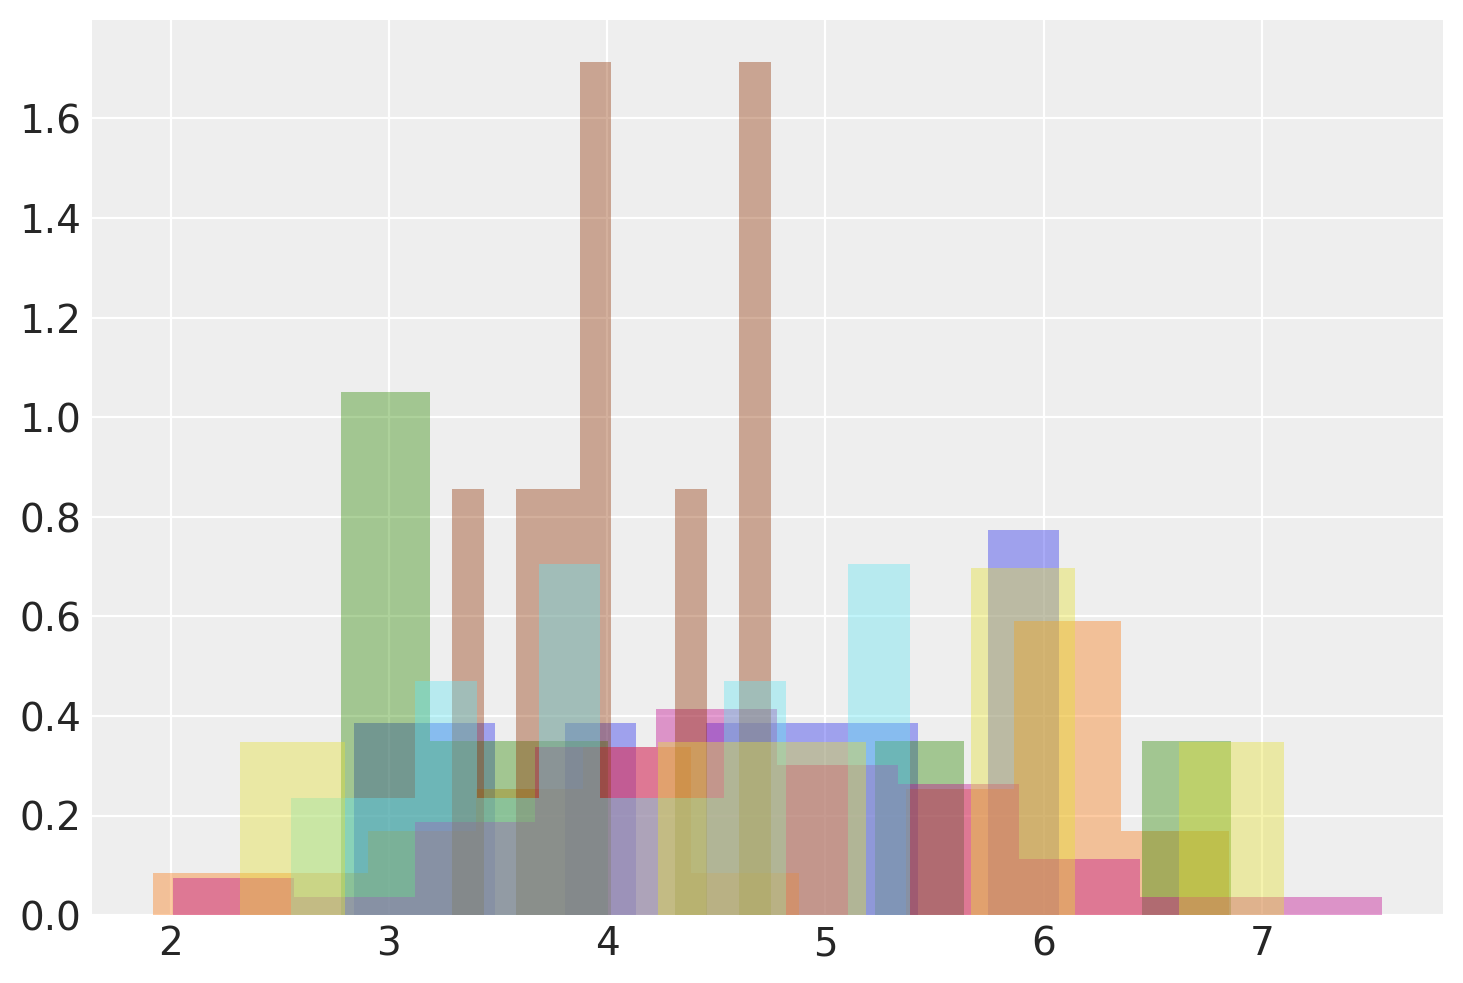

In [53]:
for x in foxy.groupsize.drop_duplicates().values:
    plt.hist(foxy[foxy.groupsize == x].weight, alpha=0.4, density=True)

In [54]:
sg = standardize(foxy.groupsize)

In [55]:
sg, sf

(0     -1.530701
 1     -1.530701
 2     -1.530701
 3     -1.530701
 4     -1.530701
          ...   
 111   -0.225103
 112   -0.225103
 113   -0.877902
 114   -0.877902
 115   -0.877902
 Name: groupsize, Length: 116, dtype: float64,
 0     -1.933180
 1     -1.933180
 2     -1.122886
 3     -1.122886
 4     -1.325459
          ...   
 111   -0.413879
 112   -0.413879
 113   -1.730606
 114   -1.730606
 115   -1.730606
 Name: avgfood, Length: 116, dtype: float64)

In [56]:
# impact of average food on weight
with pm.Model() as food_group_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    bf = pm.Normal("bf", mu=0, sd=0.5)  # food parameter
    bg = pm.Normal("bg", mu=0, sd=0.5)  # group parameter
    mu = a + bf*sf + bg*sg
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=sw)
    sample = pm.sample(draws=250, chains=4)
    #prior_preds = pm.sample_prior_predictive(samples = 100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bg, bf, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 6 seconds.


In [57]:
pm.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.080,-0.148,0.148,0.003,0.003,775.0,431.0,791.0,573.0,1.01
bf,0.472,0.181,0.141,0.821,0.007,0.005,635.0,635.0,644.0,559.0,1.00
bg,-0.566,0.187,-0.921,-0.233,0.008,0.005,608.0,608.0,611.0,503.0,1.01
sigma,0.961,0.064,0.834,1.075,0.002,0.002,682.0,682.0,701.0,369.0,1.01


We can see that the group size has a negative effect on the weight of the animals. This makes intuitive sense, as a large group size for a given amount of food means that there are less calories available per wolf, limiting their growth.

6H6. Consider your own research question. Draw a DAG to represent it. What are the testable
implications of your DAG? Are there any variables you could condition on to close all backdoor
paths? Are there unobserved variables that you have omitted? Would a reasonable colleague imagine
additional threats to causal inference that you have ignored?

Answer: Too open ended for this notebook

6H7. For the DAG you made in the previous problem, can you write a data generating simulation for
it? Can you design one or more statistical models to produce causal estimates? If so, try to calculate
interesting counterfactuals. If not, use the simulation to estimate the size of the bias you might expect.
Under what conditions would you, for example, infer the opposite of a true causal effect?

Answer: Ditto

# Test

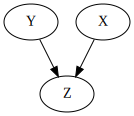

In [58]:
Test = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"),
        ("Y", "Z")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Test.draw()

In [59]:
x = np.random.normal(size=100)
y = np.random.normal(loc=6*x)
z = np.random.normal(loc=7 + x*6 + 12*y)

In [60]:
# impact of average food on weight
with pm.Model() as food_group_on_weight:
    a = pm.Normal("a", mu=0, sd=10)
    bx = pm.Normal("bx", mu=0, sd=7)  # food parameter
    # by = pm.Normal("by", mu=0,sd=7)#group parameter
    mu = a + bx*x
    sigma = pm.Exponential("sigma", 1)
    output = pm.Normal("output", mu=mu, sd=sigma, observed=y)
    sample = pm.sample(draws=250, chains=4)
    #prior_preds = pm.sample_prior_predictive(samples = 100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 8 seconds.
INFO (theano.gof.compilelock): Waiting for existing lock by process '16003' (I am process '15241')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/aidan/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir


In [61]:
pm.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.053,0.102,-0.142,0.232,0.003,0.003,1264.0,697.0,1279.0,788.0,1.0
bx,6.035,0.102,5.849,6.229,0.003,0.002,1611.0,1611.0,1637.0,730.0,1.0
sigma,1.057,0.075,0.933,1.201,0.002,0.002,1242.0,1200.0,1289.0,708.0,1.0


In [62]:
# impact of area on weight
with pm.Model() as food_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sa
    sigma = pm.Exponential("sigma", 1)
    divorce = pm.Normal("divorce", mu=mu, sd=sigma, observed=sd)
    sample = pm.sample(draws=1000, chains=4)

ValueError: Input dimension mis-match. (input[0].shape[0] = 50, input[1].shape[0] = 116)

In [ ]:
x = np.linspace(-2, 2, 10)
post_dist = sample["a"] + np.outer(x, sample["b"])
post_preds = np.random.normal(loc=post_dist, scale=sample["sigma"])
posterior_intervals = pm.hpd(post_dist.T, hdi_prob=0.89)
prediction_intervals = pm.hpd(post_preds.T, hdi_prob=0.89)
plt.plot(x, np.mean(post_dist, axis=1))
plt.fill_between(
    x, posterior_intervals[:, 0], posterior_intervals[:, 1], alpha=0.4)
plt.plot(x, np.mean(post_preds, axis=1))
plt.fill_between(
    x, prediction_intervals[:, 0], prediction_intervals[:, 1], alpha=0.4)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [ ]:
plt.plot(x, y)

In [ ]:
sample["b"][:, 0].mean()

In [ ]:
plt.hist(data[south == 1].Divorce, alpha=0.5, density=True)
plt.hist(data[south == 0].Divorce, alpha=0.5, density=True)
plt.plot(np.linspace(6, 12), stats.norm.pdf(np.linspace(6, 12),
                                            loc=sample["b"][:, 0].mean(), scale=sample["sigma"].mean()))
plt.plot(np.linspace(6, 12), stats.norm.pdf(np.linspace(6, 12),
                                            loc=sample["b"][:, 1].mean(), scale=sample["sigma"].mean()))

In [ ]:
data1 = pd.read_csv("./data/Howell1.csv", delimiter=";")
ad_height = data1[data1["age"] >= 18]

In [ ]:
ad_height

In [ ]:
plt.hist(ad_height[data1.male == 1].height, alpha=0.5, density=True)
plt.hist(ad_height[data1.male == 0].height, alpha=0.5, density=True)

In [ ]:
ad_height.male.shape, ad_height.height.shape

In [ ]:
# lets get two bell curves from this
with pm.Model() as height:
    #a = pm.Normal("a", mu=0,sd=0.2, shape=2)
    b = pm.Normal("b", mu=155, sd=30, shape=2)
    mu = b[ad_height.male]
    sigma = pm.Exponential("sigma", 10)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=ad_height.height)
    sample = pm.sample(draws=250, chains=4)

In [ ]:
plt.hist(ad_height[data1.male == 1].height, alpha=0.5, density=True)
plt.hist(ad_height[data1.male == 0].height, alpha=0.5, density=True)
plt.plot(np.linspace(130, 180), stats.norm.pdf(np.linspace(130, 180),
                                               loc=sample["b"][:, 0].mean(), scale=sample["sigma"].mean()))
plt.plot(np.linspace(130, 180), stats.norm.pdf(np.linspace(130, 180),
                                               loc=sample["b"][:, 1].mean(), scale=sample["sigma"].mean()))
plt.show()

In [ ]:
# lets get two bell curves from this
with pm.Model() as height:
    b = pm.Normal("b", mu=155, sd=30, shape=2)
    sig = pm.Exponential("sig", 5, shape=2)
    div = pm.Normal("div", mu=b[ad_height.male],
                    sd=sig[ad_height.male], observed=ad_height.height)
    hess = pm.find_hessian(pm.find_MAP())
    sample = pm.sample(draws=250, chains=4)

In [ ]:
cov = np.linalg.inv(hess)

In [ ]:
posts = pm.trace_to_dataframe(sample)

In [ ]:
posts.cov()

In [ ]:
pm.summary(sample)

In [ ]:
sample.

In [ ]:
np.std(ad_height[data1.male == 0].height)

In [ ]:
plt.hist(ad_height[data1.male == 1].height, alpha=0.5, density=True)
plt.hist(ad_height[data1.male == 0].height, alpha=0.5, density=True)
plt.plot(np.linspace(130, 180), stats.norm.pdf(np.linspace(130, 180),
                                               loc=sample["b"][:, 0].mean(), scale=sample["sig"][:, 0].mean()))
plt.plot(np.linspace(130, 180), stats.norm.pdf(np.linspace(130, 180),
                                               loc=sample["b"][:, 1].mean(), scale=sample["sig"][:, 0].mean()))
plt.show()

In [ ]:
sns.regplot(sw[south == 1], sd[south == 1])
sns.regplot(sw[south == 0], sd[south == 0])

In [ ]:
%watermark -n -u -v -iv -w